In [23]:
%pip install pandas 
%pip install scikit-learn
%pip install matplotlib inline
%pip install seaborn


98385.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


98391.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


98397.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for inline: filename=inline-0.0.1-py3-none-any.whl size=3384 sha256=6268a7dde9a88917c6f49799c42ea67a60be83f97112d2b8cef3810f8181cafe
  Stored in directory: /Users/matineh/Library/Caches/pip/wheels/3b/4f/96/99b271562a0f2eacc085469ba99aeb03e07fa0ae01f5c3a0f5
Successfully built inline
Note: you may need to restart the kernel to use updated packages.


98408.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


Class Mapping: {0: np.int64(2), 1: np.int64(4)}
['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
Model Accuracy: 0.9667
[np.int64(2), np.int64(4)]


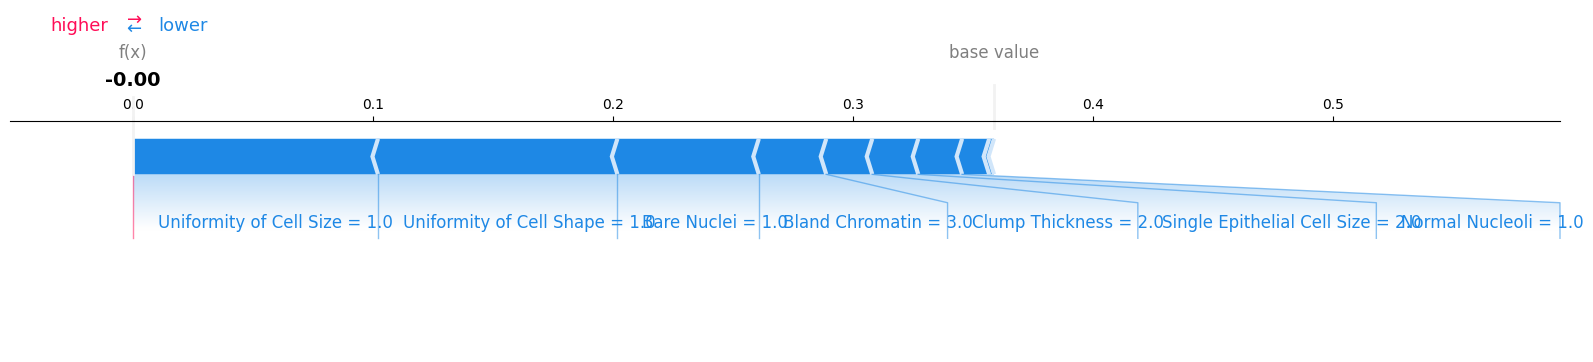

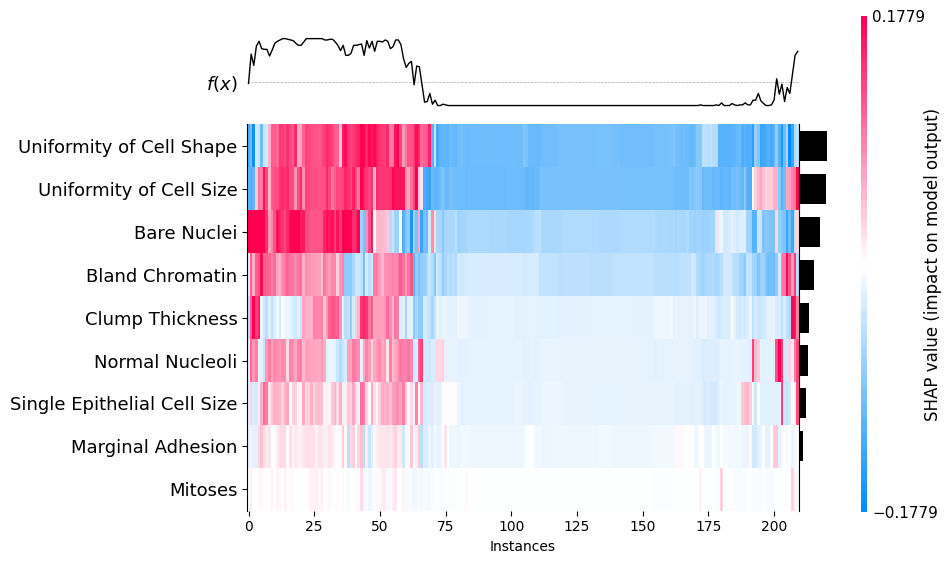

Feature importance based on mean absolute SHAP values:
                       feature  importance
0     Uniformity of Cell Shape    0.107601
1      Uniformity of Cell Size    0.104398
2                  Bare Nuclei    0.082846
3              Bland Chromatin    0.059081
4              Clump Thickness    0.037170
5              Normal Nucleoli    0.036924
6  Single Epithelial Cell Size    0.026946
7            Marginal Adhesion    0.014084
8                      Mitoses    0.004209


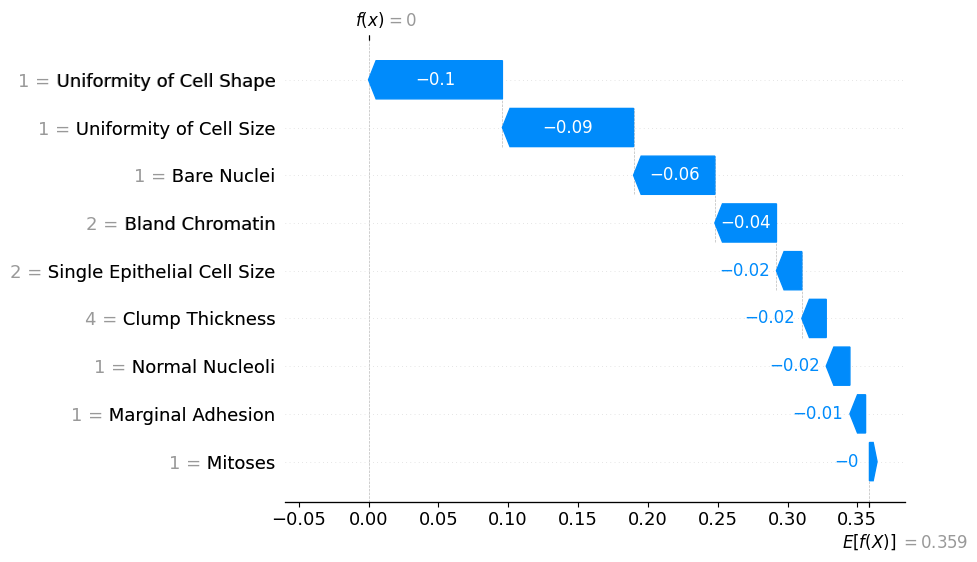

Saved results to shap_explanation_results.csv


In [8]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lime import lime_tabular

import shap 
shap.initjs()

def load_file():
    # Load Breast Cancer Wisconsin (Original) dataset from OpenML
    data = fetch_openml(data_id= 46591 , version='active', as_frame=True)
    df = data.frame.copy()
    #drop id column
    if 'Sample code number' in df.columns:
        df.drop(columns=['Sample code number'], inplace=True)
    # Handle missing values represented by '?'
    df.replace('?', np.nan, inplace=True)
    x = df.drop(columns=['Class'])
    y = df['Class']
    #convert object columns to numeric
    x = x.apply(pd.to_numeric, errors='coerce')
    #Handle missing values by imputing with column mean
    imputer = SimpleImputer(strategy='mean')
    x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)
    
    return x,y

def train_and_test(x,y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    #Create a map to understand which class is which 
    class_names = list(le.classes_)
    print (f"Class Mapping: {dict(zip(range(len(class_names)), class_names))}")
    #Split data
    x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.3, random_state=42)
    #Train Model
    forest_clf = RandomForestClassifier(random_state=42)
    forest_clf.fit(x_train, y_train)
    print(x_train.columns.tolist())
    print(f"Model Accuracy: {forest_clf.score(x_test,y_test):.4f}")
    
    return forest_clf, x_train, x_test, y_test, class_names

def explain_with_lime(clf, x_train, x_test, y_test, class_names):
        #Initialize LIME Explainer
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=x_train.values,
        feature_names=x_train.columns.tolist(),
        class_names=class_names,
        mode='classification'
    )
    
    #Explain first two instances in test set
    for i in range(2):
        actual_class = class_names[int(y_test[i])]
        print(f"Actual Status: {actual_class}")
        print(dict(zip(x_test.columns, x_test.values[i])))

        explanation = explainer.explain_instance(
            data_row=x_test.values[i],
            predict_fn=clf.predict_proba,
            num_features=9
        )
        
        # Visualize LIME explanation
        fig = explanation.as_pyplot_figure()
        plt.tight_layout()
        plt.show()
        
def explain_with_shap(clf, x_train, x_test, y_test, class_names):
    #shap.kmeans():summerize the data with centroids
    explainer= shap.TreeExplainer(clf)
    shap_values = explainer(x_test)
    #Explicitly get SHAP values for class 1
    shap_values_class = shap_values[:,:,1]
    #Beeswarm plot
    #shap.summary_plot(shap_values_class, x_test, feature_names=x_train.columns.tolist())
    #explain individual decision 
    shap.force_plot(
        explainer.expected_value[1], 
        shap_values_class[10,:].values,
        x_test.iloc[10], 
        feature_names=x_train.columns.tolist(), 
        matplotlib=True)
    #heatmap of SHAP values
    shap.plots.heatmap(shap_values_class, show= True) 
    #calculate mean absolute importance per feature 
    mean_abs_shap_values = np.abs(shap_values_class.values).mean(axis=0)
    #create sorted dataframe of feature importance
    df_feature_importance= pd.DataFrame({'feature': x_train.columns.tolist(), 
                                         'importance': mean_abs_shap_values
                                         })
    df_sorted_importance= df_feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)
    print("Feature importance based on mean absolute SHAP values:")
    print(df_sorted_importance)
    #waterfall plot for first instance
    waterfall_explanation = shap.Explanation(
        values = shap_values_class[1,:],
        base_values= explainer.expected_value[1],
        data= x_test.iloc[1],
        feature_names= x_train.columns.tolist()
    )
    shap.plots.waterfall(waterfall_explanation, max_display=10, show=True)      
    
    exp= shap.Explanation(
        values=shap_values_class.values,
        base_values=explainer.expected_value[1],
        data=x_test.values,
        feature_names=x_train.columns.tolist()
    )
    shap_df = []
    for i in range(len(x_test)):
        x = pd.DataFrame({
            'id' : x_test.index[i],
            'feature': x_test.columns,
            'feature_value': x_test.values[i],
            'base_value': exp[i].base_values,
            'shap_value': exp[i].values
        })
        shap_df.append(x)  
    final_shap_df = pd.concat(shap_df, axis=0)
    sorted_shap_df = final_shap_df.sort_values(by=['id','shap_value'], ascending=[True, False])
    sorted_shap_df.to_csv("shap_explanation_results.csv", index=False)
    print("Saved results to shap_explanation_results.csv")
    

def main():

    x,y = load_file()
    clf, x_train, x_test, y_test, class_names = train_and_test(x,y)
    print(class_names)
    #explain_with_lime(clf, x_train, x_test, y_test, class_names)
    explain_with_shap(clf, x_train, x_test, y_test, class_names)
    
if __name__ == "__main__":
    main()

